In [1]:
import numpy as np
import tensorflow as tf
import cv2
import PIL
import math
import imutils
import os
import matplotlib.pyplot as plt
import random


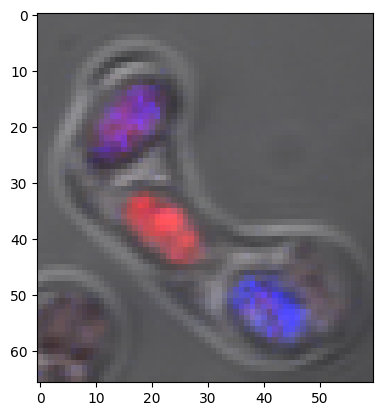

In [2]:
import os
import math
image = cv2.imread('/Users/aaditmahajan/Documents/segregation_data/mi_pssc/0327-0338.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
result = image.copy()

1. raw image input
2. process for isolating different colored spores
3. keep one grayscale background 
4. find centers of each different spore positions in:
    a. red 
    b. blue
    c. pink
    d. blank (from the background)

In [3]:
def red_spores(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    res = image.copy()
    lower_blue = np.array([200, 0, 0])
    upper_blue = np.array([255, 255, 200])
    mask_blue = cv2.inRange(image, lower_blue, upper_blue)
    res = cv2.bitwise_and(image, image, mask = mask_blue)
    return res

def blue_spores(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])

    lower2 = np.array([175,100,20])
    upper2 = np.array([190,255,255])
    
    lower_mask = cv2.inRange(hsv, lower1, upper1)
    upper_mask = cv2.inRange(hsv, lower2, upper2)

    full_mask = lower_mask + upper_mask

    res = cv2.bitwise_and(result, result, mask = full_mask)
    return res

def pink_spores(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    up = np.array([166, 255, 255])
    lp = np.array([150, 100, 0])
    mp = cv2.inRange(hsv, lp, up)
    res = cv2.bitwise_and(image, image, mask = mp)
    return res


In [20]:
spgray.shape

(66, 60)

In [21]:
def find_centers(image, spores):
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	
	blur = cv2.GaussianBlur(gray, (5, 5), 0)
	ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

	plt.subplot(1, 3, 1)
	plt.imshow(thresh)
	plt.title('threshold image')

	kernel = np.ones((3,3),np.uint8)
	opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
	# sure background area
	sure_bg = cv2.dilate(opening,kernel,iterations=3)
	# Finding sure foreground area
	dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
	ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
	# Finding unknown region
	sure_fg = np.uint8(sure_fg)
	unknown = cv2.subtract(sure_bg,sure_fg)
	ret, markers = cv2.connectedComponents(sure_fg)
	# Add one to all labels so that sure background is not 0, but 1
	markers = markers+1
	# Now, mark the region of unknown with zero
	markers[unknown==255] = 0
	plt.subplot(1, 3, 2)
	plt.imshow(markers)
	plt.title('sure fg')

	markers = cv2.watershed(spores,markers)
	spores[markers == -1] = [255,0,0]
	plt.subplot(1, 3, 3)
	plt.imshow(markers)
	plt.title('watershed masks')
	plt.show()
	
	mask_center_coords = []
	for marker in np.unique(markers):
		if marker == 0:
			continue
		# otherwise, allocate memory for the label region and draw
		# it on the mask
		mask = np.zeros(image.shape[0:2], dtype="uint8")
		mask[markers == marker] = 255
		# detect contours in the mask and grab the largest one
		cntrs = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
		cntrs = imutils.grab_contours(cntrs)
		c = max(cntrs, key=cv2.contourArea)
		# draw a circle enclosing the object
		((x, y), r) = cv2.minEnclosingCircle(c)
		# cv2.circle(spores, (int(x), int(y)), int(r), (0, 255, 0), 2)
		# cv2.putText(spores, "#{}".format(marker), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
		mask_center_coords.append((x, y))
	
	frame_dims = image.shape
	frame_center = ((frame_dims[1]-1)/2, (frame_dims[0]-1)/2)
	
	centers = []
	for center in mask_center_coords:
		if center != frame_center:
			centers.append(center)

		# print(centers)
	
	return centers


# plt.imshow(spores)
# plt.show()



find spore centers 

the catch is to isolate blank positions cell centers

either use the fact that theres one less entry in the center_coords array

or try to find the spore positions in grayscale of the complete image with background 

and then try to eliminate the existing spore centers by having a buffer around the centers 

returned by the find_centers function. 




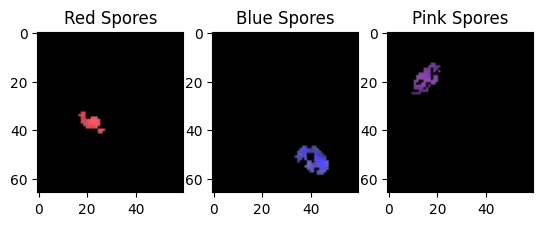

RED MASKS: 


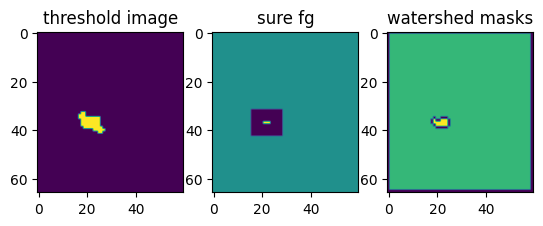

Red spore center positions:  [(21.5, 37.0)]
----------------------------------------------------------------
BLUE MASKS: 


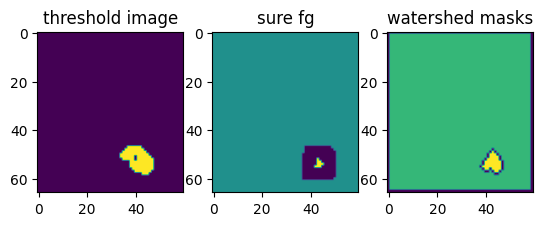

Blue spore center positions:  [(42.90909194946289, 53.272727966308594)]
----------------------------------------------------------------
PINK_MASKS: 


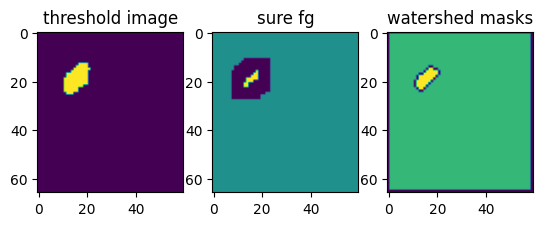

Pink spore center positions:  [(16.0, 19.0)]


In [22]:
spores_red = red_spores(image)
spores_blue = blue_spores(image)
spores_pink = pink_spores(image)

plt.subplot(1, 3, 1)
plt.imshow(spores_red)
plt.title('Red Spores')
plt.subplot(1, 3, 2)
plt.imshow(spores_blue)
plt.title('Blue Spores')
plt.subplot(1, 3, 3)
plt.imshow(spores_pink)
plt.title('Pink Spores')
plt.show()

spores = spores_red+spores_pink + spores_blue
spgray = cv2.cvtColor(spores, cv2.COLOR_BGR2GRAY)

print('RED MASKS: ')
red_centers = find_centers(spores_red, spores)
print('Red spore center positions: ', red_centers)
print('----------------------------------------------------------------')
print('BLUE MASKS: ')
blue_centers = find_centers(spores_blue, spores)
print('Blue spore center positions: ', blue_centers)
print('----------------------------------------------------------------')
print('PINK_MASKS: ')
pink_centers = find_centers(spores_pink, spores)
print('Pink spore center positions: ', pink_centers)



In [6]:
# removing frame_centers from the centers returned in the find_center function

image.shape
frame_dims = image.shape
frame_center = ((frame_dims[1]-1)/2, (frame_dims[0]-1)/2)
print(frame_center)
centers = []
for center in red_centers:
    if center != frame_center:
        centers.append(center)

print(centers)


(29.5, 32.5)
[(21.5, 37.0)]


In [7]:
image.shape

(66, 60, 3)

Finding centers has worked for each type of spore (red blue pink)
have to try and develop a relative position function

stretching the image along the longer axis should work
(if the image is square then any axis works)
although this is image processing again and expensive on memory

could multiply the axis length to the coordinates to amplify the relative positions. 

xrs = x red score
yps = y pink score
ybs = y blue score


In [8]:
def process_centers(centers, img_dims):
    hflag = False
    if img_dims[1]>img_dims[0]:
        hflag = True
    scores = []
    if hflag == True:
        for center in centers:
            score = center[0]*img_dims[0]
            scores.append(score)
    else:
        for center in centers:
            score = center[1]*img_dims[1]
            scores.append(score)
    
    return scores

scores = []
sequence = []
seq_string = ''
if pink_centers != []:
    ps = process_centers(pink_centers, image.shape)
    for i in range(len(ps)):
        sequence.append('P')
        seq_string+= 'P'
    for val in ps:
        scores.append(val)

if red_centers != []:
    rs = process_centers(red_centers, image.shape)
    for i in range(len(rs)):
        sequence.append('R')
        seq_string += 'R'
    for val in rs:
        scores.append(val)

if blue_centers != []:
    bs = process_centers(blue_centers, image.shape)
    for i in range(len(bs)):
        sequence.append('B')
        seq_string += 'B'
    for val in bs:
        scores.append(val)

print('init sequence', sequence)

#   bubble sort implementation (couldn't use the inbuilt sort function 
#   because of the operation required to be done to the sequence string)

n = len(scores)

for i in range(n):
    swapped = False

    for j in range(0, n-i-1):

        if scores[j] > scores[j+1]:
            scores[j], scores[j+1] = scores[j+1], scores[j]
            sequence[j], sequence[j+1] = sequence[j+1], sequence[j]
            seq_string[j], seq_string[j+1] = seq_string[j+1], seq_string[j]
            swapped = True
    if (swapped == False):
        break
    
print('sorted sequence: ', sequence)
print('sorted sequence string: ', seq_string)
print('sorted scores: ', scores)


init sequence ['P', 'R', 'B']
sorted sequence:  ['P', 'R', 'B']
sorted sequence string:  PRB
sorted scores:  [1140.0, 2220.0, 3196.3636779785156]


mi_rs


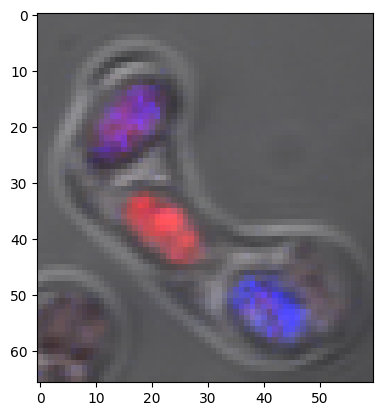

In [9]:
classifier_key = {
    'normal'    : [['B','B','R','R'], ['R','R','B','B']],
    'cco'       : [['R','B','R','B'], ['B','R','B','R'], ['B','R','R','B'], ['R','B','B','R']],
    'mi_ndj'    : [['B','R'], ['R', 'B'],['P', 'P'], ['P']],
    'mi_rs'     : [['R','B','P'], ['B','R','P'], ['P','R','B'], ['P','B','R']],
    'mi_pssc'   : [['R','B','B'], ['B','R','B'], ['R','B','R'], ['B','B','R'], ['B','R','R'], ['R','R','B'],['R','P','B'],['B','P','R']],
    'mii_pssc'  : [['R','B'], ['B','R']]
}
string_class_key = {
    'normal'    : ['BBRR', 'RRBB'],
    'cco'       : ['RBRB', 'BRBR', 'BRRB', 'RBBR'],
    'mi_ndj'    : ['RB', 'BR','PP', 'P'],
    'mi_rs'     : ['RBP', 'BRP', 'PRB', 'PBR'],
    'mi_pssc'   : ['RBB', 'BRB', 'RBR', 'BBR', 'BRR', 'RRB','RPB','BPR'],
    'mii_pssc'  : ['RB', 'BR']
}

cell_type = ''

for key, val in classifier_key.items():
    for seq in val:
        if seq == sequence:
            cell_type = key

subset_key = ''

for key, val in string_class_key.items():
    for seq in val:
        if (seq.find(seq_string) != -1) & (cell_type == ''):
            subset_key = key

if cell_type == '':
    print('other')
    print('subset_key: ', subset_key)
else:  
    print(cell_type)

plt.imshow(image)
plt.show()